In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

# Unstructured Text

* Lecture Credits (First half):
    - [Berkeley: DS100](https://docs.google.com/presentation/d/1ECr_XrDJXaLK-eGwWlydLjJu-3xwpzFcV4fGMSfwKwU/edit?usp=sharing)
    - [Princeton: COS226](http://www.cs.princeton.edu/courses/archive/spring17/cos226/lectures/54RegularExpressions.pdf)

## Outline

* Canonicalization
* Regex
* Information Extraction

## Joining on text

* Will these join? What are the problems?
* How would you clean the dataframes to join them?
<img src="imgs/image_0.png">

## Joining on text: cleaning the join key
* Upper vs lower case
* Words "county" and "parish" don't add information in these datasets
* Take care of common variants of words
* Take care of punctuation

In [4]:
county_and_state = pd.read_csv("data/county_and_state.csv")
county_and_pop = pd.read_csv("data/county_and_pop.csv")

In [5]:
display(county_and_state)
display(county_and_pop)

,County,State
0,De Witt County,IL
1,Lac qui Parle County,MN
2,Lewis and Clark County,MT
3,St John the Baptist Parish,LA


,County,Population
0,DeWitt,16798
1,Lac Qui Parle,8067
2,Lewis & Clark,55716
3,St. John the Baptist,43044


In [6]:
# Naive join
county_and_state.merge(county_and_pop)

,County,State,Population


In [7]:
def clean_county(county):
    return (county
            .lower()
            .strip()
            .replace(' ', '')
            .replace('county', '')
            .replace('parish', '')
            .replace('&', 'and')
            .replace('.', ''))

In [8]:
county_and_pop['County'] = county_and_pop['County'].apply(clean_county)
county_and_pop

,County,Population
0,dewitt,16798
1,lacquiparle,8067
2,lewisandclark,55716
3,stjohnthebaptist,43044


In [9]:
county_and_state['County'] = county_and_state['County'].apply(clean_county).to_frame()
county_and_state

,County,State
0,dewitt,IL
1,lacquiparle,MN
2,lewisandclark,MT
3,stjohnthebaptist,LA


In [10]:
county_and_state.merge(county_and_pop)

,County,State,Population
0,dewitt,IL,16798
1,lacquiparle,MN,8067
2,lewisandclark,MT,55716
3,stjohnthebaptist,LA,43044


## Canonicalization
* Create a sequence of steps that transforms both columns into a single form.

<img src="imgs/image_1.png">

## Canonicalization

Replace each string with a unique representation.
- Used string methods
- Very brittle procedure; may only work for X% of the data.
- Hard to verify correctness.
- Also *parse* data using a data model if given the choice!

### Question: limitations of string methods 

* Suppose we want to extract the date and time from the following string:
```
170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585
```
* How would you do this?

### Limitations of string methods 

```
170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585
```
Steps:
1. Get string between `[` and `]`
2. Parse date as day/month/year:hour:min:sec without the timezone
    - in `strftime` format: `%d/%b/%y:%H:%M:%S`
    
What could go wrong with this technique?

In [11]:
s = '''170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585'''

dt = s[s.find('[') + 1:s.find(']') - 6]
dt

'14/Mar/2018:12:09:20'

In [12]:
dt.split('/')

['14', 'Mar', '2018:12:09:20']

In [13]:
day, month, year_time = dt.split('/')

In [14]:
year_time

'2018:12:09:20'

In [15]:
year, hour, minute, second =  year_time.split(':')

In [16]:
year, month, day, minute, second

('2018', 'Mar', '14', '09', '20')

In [17]:
dt

'14/Mar/2018:12:09:20'

In [18]:
pd.to_datetime(dt)

ParserError: Unknown string format: 14/Mar/2018:12:09:20

In [19]:
# better: if date format changes, will throw a descriptive error! (good!)
pd.to_datetime(dt, format='%d/%b/%Y:%H:%M:%S')

# https://strftime.org/

Timestamp('2018-03-14 12:09:20')

## Regular Expressions (`regexp`)

* Fast, compact way of matching patterns in text
* Python library: `import re`
* Advantages: powerful; capable of matching very complex patterns.
* Disadvantages: 
    - It's still text processing, so brittle and likely to break.
    - Hard to understand: "write-only" language.

## Regular expression solution to log parsing
* Regex pattern uses the same logic as log parsing

In [38]:
s

'170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585'

In [39]:
import re
pat = '\[(.+)\/(.+)\/(.+):(.+):(.+):(.+) .+\]'
re.findall(pat, s)

[('14', 'Mar', '2018', '12', '09', '20')]

## Regular Expressions: the more specific, the better!
* Be as specific in your pattern matching as possible
    - Easier to validate the extracted text
    - Easier for error handling (understanding what went wrong).
    
* A better date extraction pattern uses:
```
'\[([0-9]{2}\/[A-Z]{1}[a-z]{2}\/[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2} -[0-9]{4})\]'
```

In [22]:
s = '170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585'
s

'170.242.51.168 - - [14/Mar/2018:12:09:20 -0800] "GET /my/home/ HTTP/1.1" 200 2585'

In [23]:
pat1 = '\[(.+\/.+\/.+:.+:.+:.+ .+)\]'
re.findall(pat1, s)

['14/Mar/2018:12:09:20 -0800']

In [24]:
pat2 = '\[([0-9]{2}\/[A-Z]{1}[a-z]{2}\/[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2} -[0-9]{4})\]'
re.findall(pat2, s)

['14/Mar/2018:12:09:20 -0800']

## Regexp Expressions
* Parsing the expression:
```
'\[([0-9]{2}\/[A-Z]{1}[a-z]{2}\/[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2} -[0-9]{4})\]'
```

* `[0-9]{2}` matches any 2-digit number.
* `[A-Z]{1}` matches any single occurrence of any upper-case letter.
* `[a-z]{2}` matches any 2 consecutive occurrences of lower-case letters.
* Certain special characters (`[`, `]`, `/`) need to be escaped with `\`

In [25]:
# Why is pattern 2 better?
t = '[adr/jduy/wffsdffs:r4s4:4wsgdfd:asdf 7]'

In [26]:
t

'[adr/jduy/wffsdffs:r4s4:4wsgdfd:asdf 7]'

In [27]:
re.findall(pat, t)

[('adr', 'jduy', 'wffsdffs', 'r4s4', '4wsgdfd', 'asdf')]

In [28]:
# Easy to check if something mis-parsed: empty list!
re.findall(pat2, t)

[]

## Regular Expressions: Applications

* Source Code: IDE syntax highlighting
* Google Code Search
* Scanning for viruses
* Validating text for data-entry

## You may already know regular expressions
* Google supports wildcard search `*` and union `|`
![google](imgs/regex_google.png)

### Regular Expression Syntax

* The four 'building blocks' for all regular expressions:
    - "order" specifies "order of operations"

<img src="imgs/image_2.png">

In [29]:
re.search('ABA', 'ABAAAAAA')

<re.Match object; span=(0, 3), match='ABA'>

In [30]:
re.search('ABA', 'AAAAABAAAAAA')

<re.Match object; span=(4, 7), match='ABA'>

In [31]:
# examples of each
re.search('AB*A', 'ABBBBBBA')

<re.Match object; span=(0, 8), match='ABBBBBBA'>

In [32]:
re.search('AB*A', 'ABA')

<re.Match object; span=(0, 3), match='ABA'>

In [33]:
re.search('AB*A', 'AA')

<re.Match object; span=(0, 2), match='AA'>

In [34]:
re.search('AB*A', 'AB')

### Discussion

1. Give a regular expression that matches "moon", "moooon", etc. 
    - Should match any **even** positive number of 'o'.
2. Give a regex that matches muun, muuuun, moon, moooon, etc. 
    - Should match any **even** positive number of 'u' and 'o'.

<img src="imgs/image_3.png">

In [35]:
re.search('moo(oo)*n|', 'moooon')

<re.Match object; span=(0, 6), match='moooon'>

In [36]:
re.search('', 'muun')

<re.Match object; span=(0, 0), match=''>

### Expanded Regexp Syntax

* The following operations offer convenience for expressive matching.

<img src="imgs/image_4.png">

* Ex. `[A-E]+` is just shorthand for `(A|B|C|D|E)(A|B|C|D|E)*`


### More Regular Expression Examples


<img src="imgs/image_5.png">

### Discussion Question

* Give a regular expression for any lowercase string that has a repeated vowel (i.e. noon, peel, festoon, looop, etc).
* Give a regular expression for any string that contains both a lowercase letter and a number, in any order. (marina20, 20marina, ma20rina etc).

<img src="imgs/image_6.png">

In [37]:
re.search('.*(aa|oo|ee|uu|ii)+.*', 'looop')

<re.Match object; span=(0, 5), match='looop'>

In [ ]:
re.search('.*[a-z][0-9]+.*|.*[0-9]+[a-z].*', 'sdf78sdf')

### Even More Regular Expressions

<img src="imgs/image_7.png">

* Anchors (`^` and `$`) will be useful on HW).
* Non-greedy qualifier is useful, but won't be used in class.

In [ ]:
re.search('a', "Marina")

## Limitations of Regular Expressions

Writing regular expressions is like writing a program.
* Need to know the syntax well.
* Can be easier to write than to read.
* Can be difficult to debug.

Regular expressions terrible at certain types of problems. Examples:
* Anything involving counting (same number of instances of a and b).
* Anything involving complex structure (palindromes).
* Parsing highly complex text structure.

### Email address validation using regexp

<img src="imgs/image_8.png">

### Regexp for data validation
* See [postmortem](http://stackstatus.net/post/147710624694/outage-postmortem-july-20-2016)
![so_regexp](imgs/so_regexp.png)

### More regexp syntax

For more regexp info, see:
* [DS100 Textbook](https://www.textbook.ds100.org/ch/08/text_regex.html)
* [Python Documentation](https://docs.python.org/3/library/re.html)

<img src="imgs/image_9.png">

## Python `re` library functions
* `re.search`:
    - `m = re.search(r, s); m.groups`
* `re.findall`
* `re.sub`

Also in Pandas: `Series.str.sub`, `Series.str.extract`, `Series.str.contains`.

## Regexp Groups (Briefly)
* Use `(` regex `)` to *extract* text from a string.

In [2]:
s

NameError: name 's' is not defined

In [1]:
ip_pattern = '([0-9]{3}\.[0-9]{3}\.[0-9]{2}\.[0-9]{3})'
dt_pattern = '\[(.*)\]'

In [ ]:
re.findall(ip_pattern, s)

In [ ]:
re.findall(dt_pattern, s)

In [ ]:
pat = '%s|%s' %(ip_pattern, dt_pattern)
pat

In [ ]:
# now have *two* possible group matches!
re.findall(pat, s)

### Example: San Diego City Employee Salaries
* Recall Lecture 01: Do men and women make similar salaries?
* Follow-up question: Do men and women make similar salaries among those with similar jobs?
    - How to determine "similar jobs?"

In [18]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2017.csv')
jobtitles = salaries['Job Title']

In [19]:
jobtitles.value_counts().iloc[:100]

Police Officer                   1977
Fire Fighter 2                    285
Rec Leader 1                      285
Grounds Maint Wrkr 2              270
Asst Eng-Civil                    238
                                 ... 
Wstwtr Operations Supv             25
Plant Procs Cntrl Electrician      25
Cement Finisher                    24
Public Works Supv                  24
Student Intern                     24
Name: Job Title, Length: 100, dtype: int64

In [20]:
jobtitles.shape[0], jobtitles.nunique()

(12493, 669)

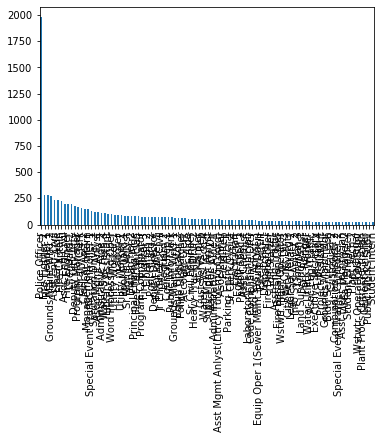

In [21]:
# plot empirical distribution

jobtitles.value_counts().iloc[:100].plot(kind='bar')


### Cleaning job titles: assessment
* Can we canonicalize job titles?
* Are they self-consistent?
    - Punctuation? Capitalization? Abbreviations?

In [22]:
# run / rerun
jobtitles.sample(10)

11539                   Rec Leader 1
5315                  Asoc Eng-Civil
6844           Personnel Assistant 2
10232                    Lifeguard 1
2788                  Police Officer
4136                  Asoc Eng-Civil
2324                  Police Officer
5925                  Asst Eng-Civil
4031     Traffic Signal Technician 1
2753               Public Works Supv
Name: Job Title, dtype: object

### Cleaning job titles: step 1
* Is every first letter capitalized?
* What punctuation exists? should it be cleaned?

In [23]:
# Capitalization
jobtitles[(
    jobtitles.str.contains(' [a-z]+ ') | 
    jobtitles.apply(lambda x:x[0].islower())
)]

186            Principal Asst to City Atty
885                 Asst to the Fire Chief
1993                  Asst to the Director
3084               Conf Secretary to Mayor
3378     Conf Secretary to Chief Oper Ofcr
3439           Asst to the Chief Oper Ofcr
4241           Conf Secretary to City Atty
4773           Asst to the Chief Oper Ofcr
4937                  Asst to the Director
6396        Conf Secretary to Police Chief
7841                  Asst to the Director
10446          Asst for Community Outreach
11384              Conf Secretary to Mayor
12398                 Asst to the Director
Name: Job Title, dtype: object

In [24]:
# punctuation: replace with space?
jobtitles[jobtitles.str.contains('[^A-Za-z0-9 ]')].head(15)

95          Deputy City Atty - Unrep
154       Park & Recreation Director
159            Asst Fire Marshal/Civ
176    Fire Captain(Emer Mgmt Coord)
184               Fire Engineer-Mast
218         Deputy City Atty - Unrep
240                Fire Captain-Mast
322      Procurement Spec (Terminal)
374                Fire Captain-Mast
422              Asoc Eng-Electrical
447            Asst Fire Marshal/Civ
481                Fire Captain-Mast
501               Fire Engineer-Mast
562          Cust Info & Billing Mgr
664         Deputy City Atty - Unrep
Name: Job Title, dtype: object

### Cleaning job titles: step 1
* Remove: to, the, for
* Replace: non-alphanumeric with space
* Replace multiple spaces with one space

In [25]:
jobtitles = (
    jobtitles
    .str.replace(' to| the| for', '')  # include the spaces! (why?)
    .str.replace("[^A-Za-z0-9' ]", ' ')
    .str.replace("'", '')
    .str.replace(' +', ' ')
)

In [26]:
jobtitles.sample(10)

8058      Grounds Maint Wrkr 2
7493     Irrigation Specialist
11823             Fire Recruit
10535             Library Aide
7884        Heavy Truck Drvr 2
9012      Grounds Maint Wrkr 2
859        Program Coordinator
9486          Utility Worker 1
8460         Public Info Clerk
7065            Rec Cntr Dir 3
Name: Job Title, dtype: object

### Cleaning job titles: abbreviations 

* Which job titles are inconsistently described?
    - Librarian? Engineer? Director?

In [27]:
jobtitles[jobtitles.str.contains('Libr')].value_counts()

Library Aide              232
Library Clerk             158
Library Assistant         102
Librarian 2                76
Librarian 3                30
Librarian 4                28
Library Technician          8
Librarian 1                 7
Supv Librarian              5
Deputy Library Dir          2
Sr Library Tech             1
Librarian 3 Law Librn       1
City Librarian              1
Name: Job Title, dtype: int64

In [28]:
jobtitles[jobtitles.str.contains('Eng')].value_counts()

Asst Eng Civil                              238
Asoc Eng Civil                              198
Fire Engineer                               197
Principal Engrng Aide                        82
Jr Engineer Civil                            69
Sr Civil Engineer                            57
Asst Eng Traffic                             34
Asoc Eng Traffic                             29
Student Engineer                             25
Structural Engrng Asoc                       16
Sr Traffic Engineer                          15
Sr Engineering Aide                          12
Asoc Eng Electrical                          12
Structural Engrng Sr                          9
Asoc Eng Mechanical                           8
Asst Eng Electrical                           8
Asst Eng Civil Cntrct Spec                    8
Asoc Eng Civil Sr Cntrct Spec                 7
Structural Engrng Asst                        6
Asoc Commctns Eng                             4
Asoc Eng Civil Asoc Eng Geol            

In [29]:
jobtitles[jobtitles.str.contains('Dir')].value_counts()

Deputy Director                    71
Asst Rec Ctr Dir                   49
Rec Cntr Dir 3                     33
Asst Deputy Director               16
Rec Cntr Dir 2                     14
Department Director                11
Executive Director                 10
Rec Cntr Dir 1                     10
Asst Department Director            8
Asst Director                       4
Public Utilities Director           2
Deputy Pers Director                2
Deputy Library Dir                  2
Park Recreation Director            1
Asst Environmental Services Dir     1
Deputy Planning Director            1
Development Services Dir            1
Asst Metro Wstwtr Dir               1
Planning Director                   1
Risk Management Director            1
Asst Planning Director              1
Personnel Director                  1
Environmental Services Dir          1
Real Estate Assets Dir              1
Asst Pers Director                  1
Name: Job Title, dtype: int64

### The limits of canonicalization
* How do we find which common words to map a job title to?
    - E.g. pattern matching on 'Eng' or 'Libr'
* What about other titles? (there are too many!)
* Adjectives vs Nouns have different meanings
    - Junior/Senior/Director vs Police/Fire/Engineer

### The limits of canonicalization

Naive procedure: 
1. Compute most common words
2. Select "relevant" words using domain expertise
3. Check if a given word is contained in a given job title.

In [30]:
# compute counts of all words (together)
bow = jobtitles.str.split().sum()
words = pd.Series(bow).value_counts()
words.head(10)

2          2278
Police     2160
Officer    2001
1          1555
Fire       1017
Asst        751
Aide        615
Civil       584
Eng         559
Sr          531
dtype: int64

In [31]:
len(words)

464

In [32]:
# is a given word in a job-title? count number of occurances of each
jobtypes = pd.DataFrame([], index=salaries.index)
for word in words.index:
    re_pat = '\\b{word}\\b'.format(word=word)
    jobtypes[word] = jobtitles.str.count(re_pat).astype(int)

In [33]:
jobtypes.head(10)

,2,Police,Officer,1,Fire,Asst,Aide,Civil,Eng,Sr,...,Fewd,Motve,Comptroller,Technical,Invstgtns,Documents,Env,Stores,Employment,Roofing
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# how many columns? (curse of dimensionality)
len(jobtypes.columns)

464

In [35]:
jobtypes.iloc[:,:20].sum()

2          2278
Police     2160
Officer    2001
1          1555
Fire       1017
Asst        751
Aide        615
Civil       584
Eng         559
Sr          531
Asoc        525
Library     503
Rec         499
Anlyst      494
3           481
Tech        472
Supv        444
Maint       444
Fighter     430
Clerk       410
dtype: int64

In [36]:
# What about those with sum = 0? sum > 1?
jobtypes.iloc[:,:20].sum(axis=1).describe()

count    12493.000000
mean         1.340991
std          0.873223
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
dtype: float64

### What are the closest job titles to 'Asst Fire Chief'


* Idea: which other job titles share "the most" words in common?
* Implementation: use the 'word vectors' in `jobtypes` to count up matching words.

In [37]:
# what are the closest job titles to:
jobidx = 109
job = jobtitles.iloc[jobidx]
job

'Asst Fire Chief'

In [38]:
job1 = jobtitles.iloc[0]
job1

'Fire Battalion Chief'

In [39]:
# word vectors side-by-side
pd.concat([jobtypes.iloc[0], jobtypes.iloc[109]], axis=1).head(10)

,0,109
2,0,0
Police,0,0
Officer,0,0
1,0,0
Fire,1,1
Asst,0,1
Aide,0,0
Civil,0,0
Eng,0,0
Sr,0,0


In [40]:
cnts = pd.concat([jobtypes.iloc[0], jobtypes.iloc[109]], axis=1)

(cnts.iloc[:,0] * cnts.iloc[:,1]).head(10).to_frame()

,0
2,0
Police,0
Officer,0
1,0
Fire,1
Asst,0
Aide,0
Civil,0
Eng,0
Sr,0


In [41]:
# sum the matches
np.sum(cnts.iloc[:,0] * cnts.iloc[:,1])

2

## Solution attempt 1: bag of words
1. Create a list of all words appearing among *all* text ('bag of words')
2. Create a vector, indexed by the distinct words, with counts of the words in that entry.
3. Two text entries are similar if the sum of their matches is large.
    - The sum of their matches is the same as the dot-product of the vectors!

### Discussion Question

Given the list of sentences below:
1. What is the index for the word vectors of the sentences?
2. How close are the word-vectors of the first and second sentence?

In [42]:
sentences = [
    'the fox and the moon',
    'the cow and the moon',
    'the cow and the spoon'
]
pd.Series(sentences).to_frame()

,0
0,the fox and the moon
1,the cow and the moon
2,the cow and the spoon


### Answer

In [43]:
sentences = pd.Series(sentences)
sentences

0     the fox and the moon
1     the cow and the moon
2    the cow and the spoon
dtype: object

In [44]:
words = pd.Series(sentences.str.split().sum()).value_counts()
words

the      6
and      3
moon     2
cow      2
spoon    1
fox      1
dtype: int64

In [45]:
wordvecs = pd.DataFrame([], index=sentences.index)
for word in words.index:
    re_pat = '\\b%s\\b' % word
    wordvecs[word] = sentences.str.count(re_pat).astype(int)
    
wordvecs

,the,and,moon,cow,spoon,fox
0,2,1,1,0,0,1
1,2,1,1,1,0,0
2,2,1,0,1,1,0


In [46]:
np.sum(wordvecs.iloc[0] * wordvecs.iloc[1])

6

### Bag of Words: Salaries
* Compute the sum of matches among all word vectors and 'Asst Fire Chief'
* Take the job that is the closest match

In [47]:
jobtitles.iloc[jobidx]

'Asst Fire Chief'

In [48]:
jobvec = jobtypes.iloc[jobidx]
jobvec.head()

2          0
Police     0
Officer    0
1          0
Fire       1
Name: 109, dtype: int32

In [49]:
# dot product with 'Asst Fire Chief' and *all* other titles
matches = jobtypes.apply(lambda ser: np.dot(jobvec, ser), axis=1)
matches.head(10)

0    2
1    1
2    1
3    2
4    1
5    1
6    2
7    0
8    1
9    2
dtype: int64

In [50]:
jobtitles.loc[matches.sort_values(ascending=False).index].head(10)

174           Asst Fire Chief
885           Asst Fire Chief
109           Asst Fire Chief
0        Fire Battalion Chief
114      Fire Battalion Chief
237      Fire Battalion Chief
215      Fire Battalion Chief
3439     Asst Chief Oper Ofcr
159     Asst Fire Marshal Civ
5988     Fire Battalion Chief
Name: Job Title, dtype: object

## Summary: Bag of Words

* Create an index out of *all* distinct words 
    - The basis for the vector space of words.
* Create vectors for each text entry by computing the counts of words in the entry.
* The dot product between two vectors is proportional to their 'similarity':
    - This defines the **cosine similarity** between vectors via: $$dist(v, w) = 1 - \cos(\theta) = 1 - \frac{v \cdot w}{|v||w|}$$

### Conclusion: Bag of Words
* Bag of words *embeds words into a vector space*
* Can then use clustering (e.g. k-means) to group like words (e.g. into 'job-types')
    - Unfortunately, many clustering techniques don't work well in high dimensions.
* Downside: treats all words as *equally important*.
    - "Asst Fire Chief" vs "Asst Chief Oper Ofcr"

## TF-IDF

Term Frequency / Inverse Document Frequency

### Term Frequency, Inverse Document Frequency

How do we figure out which words are "important" in a document?

1. The most common words often *don't* have much meaning!
2. The very rare words are also less important!

Goal: balance these two observations.

## Term Frequency, Inverse Document Frequency

* The *term frequency* of a word $t$ in a document $d$, denoted ${\rm tf}(t,d)$, is the likelihood of the term appearing in the document.
   * Word that occurs often is important to document meaning.

* The *document frequency* is how often the a words occurs in the entire set of documents.
   * Common words that appear everywhere.


* Question: what are the frequencies for a word "the"? (high/low?)

## What about their ratio? Intuition

The relevance of this word to the document.

$$\frac{{\rm\ TermFrequency}}{{\rm DocumentFrequncy}}$$

* `TF`: High, `DC`: High
* `TF`: High, `DC`: Low
* `TF`: Low, `DC`: High
* `TF`: Low, `DC`: Low

## Term Frequency, Inverse Document Frequency

* The *term frequency* of a word $t$ in a document $d$, denoted ${\rm tf}(t,d)$, is the likelihood of the term appearing in the document.
* The *inverse document frequency* of a word $t$ in a set of documents $\{d_i\}$, denoted ${\rm idf}(t,d)$ is: 

$$\log(\frac{{\rm\ total\ number\ of\ documents}}{{\rm number\ of\ documents\ in\ which\ t\ appears}})$$

* The *tf-idf* of a term $t$ in document $d$ is given by the product: 

$${\rm tfidf}(t,d) = {\rm tf}(t,d) \cdot {\rm idf}(t)$$

In [51]:
# What is the tf-idf of 'cow' in the second 'document'?
sentences.to_frame()

,0
0,the fox and the moon
1,the cow and the moon
2,the cow and the spoon


### Answer

In [52]:
# the term frequency of 'cow' in the second 'document'
tf = sentences.iloc[1].count('cow') / (sentences.iloc[1].count(' ') + 1)
tf

0.2

In [53]:
idf = np.log(len(sentences) / sentences.str.contains('cow').sum())

In [60]:
sentences.str.contains('cow').sum()

2

In [54]:
idf

0.4054651081081644

In [55]:
tf * idf

0.08109302162163289

### TF-IDF of all terms in all documents
* What are the different reasons tf-idf can be zero?
* When is it the largest?

In [ ]:
sentences

In [ ]:
words = pd.Series(sentences.str.split().sum())

In [ ]:
tfidf = pd.DataFrame([], index=sentences.index)  # dataframe of documents
for w in words.unique():
    re_pat = '\\b%s\\b' % w
    tf = sentences.str.count(re_pat) / (sentences.str.count(' ') + 1)
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf[w] = tf * idf

In [ ]:
tfidf

### Summary: TF-IDF

* Term Frequency, Inverse Document Frequency balances:
    - how often a word appears in a document/sentence, with
    - how often a word appears *across* documents.
* For a given document, the word with the highest TF-IDF best summarizes that document.

### Example: State of the Union Addresses

* What are the important words for each address?

In [61]:
sotu = open('data/stateoftheunion1790-2017.txt').read()

In [62]:
print(sotu[:20000])

The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are  from UCSB The American Presidency Project.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Address, December 8, 1798
  John Adams, State of the Union Address, December 3, 1799
  John Adams, State of the Union 

In [63]:
speeches = sotu.split('\n***\n')[1:]

In [67]:
len(speeches)
import re

In [68]:
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub("[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [69]:
df = pd.DataFrame(list(map(extract_struct, speeches)))

In [70]:
df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...
...,...,...,...,...
222,State of the Union Address,Barack Obama,"February 12, 2013",mr speaker mr vice president members of c...
223,State of the Union Address,Barack Obama,"January 28, 2014",the president mr speaker mr vice presiden...
224,State of the Union Address,Barack Obama,"January 20, 2015",the president mr speaker mr vice presiden...
225,State of the Union Address,Barack Obama,"January 12, 2016",thank you mr speaker mr vice president m...


In [71]:
words = pd.Series(df.contents.str.split().sum())

In [72]:
tfidf = pd.DataFrame([], index=df.index)  # dataframe of documents
tf_denom = (df.contents.str.count(' ') + 1)
for w in words.value_counts().iloc[0:500].index:
    # imperfect pattern match for speed
    re_pat = ' %s ' % w
    tf = df.contents.str.count(re_pat) / tf_denom
    idf = np.log(len(df) / df.contents.str.contains(re_pat).sum())
    tfidf[w] =  tf * idf

In [ ]:
tfidf.head()

In [ ]:
summaries = tfidf.idxmax(axis=1)
summaries

In [ ]:
pd.concat([summaries, df.president], axis=1).groupby('president').apply(lambda x:x[0].unique())